In [1]:
from time import perf_counter
import numpy as np
import cv2
from skimage import exposure
import matplotlib.pyplot as plt
from typing import Any
import os
from glob import glob
from skimage import exposure,measure
from skimage.segmentation import clear_border
import skimage.io
from skimage.filters import threshold_otsu,threshold_triangle,threshold_li,threshold_mean,median
from scipy import ndimage as ndi
import scipy
from skimage.morphology import area_closing,binary_closing,binary_erosion,binary_dilation,binary_opening,\
     remove_small_objects,remove_small_holes,reconstruction,erosion,closing,dilation,opening,disk

from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.feature import peak_local_max
from skimage.transform import rotate

In [2]:
def split_cell2(bw):#input image is binary
    bw3=(bw.copy())*255
    bw66=np.zeros_like(bw3,dtype=np.uint16)
    label_img = measure.label(bw3, background=0)
    props = measure.regionprops(label_img)
    kernel = np.ones((3,3),np.uint8)
    for prop in props:
        if(prop.solidity>=0.9):
            bw3[prop.bbox[0]:prop.bbox[2],prop.bbox[1]:prop.bbox[3]]=(prop.image.astype(np.uint8))
            bw66[prop.bbox[0]:prop.bbox[2],prop.bbox[1]:prop.bbox[3]]+=(prop.image.astype(np.uint8))
        else:#if(prop.solidity<0.9):
            uu=prop.image
            bg0=prop.image_convex ^ prop.image
            bg = cv2.erode((bg0*255).astype(np.uint8),kernel,iterations = 1)
            bg = cv2.morphologyEx(bg,cv2.MORPH_OPEN,kernel, iterations = 2)
            label_img1 = measure.label(bg>0, background=0)
            props1 = measure.regionprops(label_img1)
            areas=[]
            labels=[]
            for prp in props1:
                areas.append(prp.area)
                labels.append(prp.label)

            if(len(labels)==1):
                if(prop.solidity<0.8):
                    bw3[prop.bbox[0]:prop.bbox[2],prop.bbox[1]:prop.bbox[3]]=bg0.astype(np.uint8)+prop.image.astype(np.uint8)
            elif(len(labels)==2):
                areas_sorted, labels_sorted = (list(t) for t in zip(*sorted(zip(areas, labels))))
                coords1 = np.nonzero(label_img1 == labels_sorted[-1])
                coords2 = np.nonzero(label_img1 == labels_sorted[-2])
                #print(labels_sorted)
                c1=np.array(coords1).transpose()
                c2=np.array(coords2).transpose()
                distances=scipy.spatial.distance.cdist(c1, c2, 'euclidean')
                min_index = (np.argmin(distances))
                closest = np.unravel_index(min_index, distances.shape)
                p=c1[closest[0]]
                q=c2[closest[1]]
                uu=((uu>0)*255).astype(np.uint8)
                cv2.line(uu, (p[1],p[0]), (q[1],q[0]), 0, 3)

                bw3[prop.bbox[0]:prop.bbox[2],prop.bbox[1]:prop.bbox[3]]=uu

            elif(len(labels)==3):
                areas_sorted, labels_sorted = (list(t) for t in zip(*sorted(zip(areas, labels))))
                coords1 = np.nonzero(label_img1 == labels_sorted[-1])
                coords2 = np.nonzero(label_img1 == labels_sorted[-2])
                coords3 = np.nonzero(label_img1 == labels_sorted[-3])
                #print(labels_sorted)
                c1=np.array(coords1).transpose()
                c2=np.array(coords2).transpose()
                c3=np.array(coords3).transpose()

                distances1=scipy.spatial.distance.cdist(c1, c2, 'euclidean')
                distances2=scipy.spatial.distance.cdist(c1, c3, 'euclidean')
                if(np.min(distances1)<np.min(distances2)):
                    min_index = (np.argmin(distances1))
                    closest = np.unravel_index(min_index, distances1.shape)
                    q=c2[closest[1]]
                else:
                    min_index = (np.argmin(distances2))
                    closest = np.unravel_index(min_index, distances2.shape)
                    q=c3[closest[1]]

                p=c1[closest[0]]
                uu=((uu>0)*255).astype(np.uint8)
                cv2.line(uu, (p[1],p[0]), (q[1],q[0]), 0, 3)

                bw3[prop.bbox[0]:prop.bbox[2],prop.bbox[1]:prop.bbox[3]]=uu

            elif(len(labels)==4):
                areas_sorted, labels_sorted = (list(t) for t in zip(*sorted(zip(areas, labels))))
                coords1 = np.nonzero(label_img1 == labels_sorted[-1])
                coords2 = np.nonzero(label_img1 == labels_sorted[-2])
                coords3 = np.nonzero(label_img1 == labels_sorted[-3])
                coords4 = np.nonzero(label_img1 == labels_sorted[-4])
                #print(labels_sorted)
                c1=np.array(coords1).transpose()
                c2=np.array(coords2).transpose()
                c3=np.array(coords3).transpose()
                c4=np.array(coords4).transpose()

                distances1=scipy.spatial.distance.cdist(c1, c2, 'euclidean')
                distances2=scipy.spatial.distance.cdist(c1, c3, 'euclidean')
                distances3=scipy.spatial.distance.cdist(c1, c4, 'euclidean')

                t1=np.min(distances1)
                t2=np.min(distances2)
                t3=np.min(distances3)

                if(min(t1,t2,t3)==t1):
                    min_index = (np.argmin(distances1))
                    closest = np.unravel_index(min_index, distances1.shape)
                    q=c2[closest[1]]
                elif(min(t1,t2,t3)==t2):
                    min_index = (np.argmin(distances2))
                    closest = np.unravel_index(min_index, distances2.shape)
                    q=c3[closest[1]]
                else:
                    min_index = (np.argmin(distances3))
                    closest = np.unravel_index(min_index, distances3.shape)
                    q=c4[closest[1]]

                p=c1[closest[0]]
                uu=((uu>0)*255).astype(np.uint8)
                cv2.line(uu, (p[1],p[0]), (q[1],q[0]), 0, 3)

                bw3[prop.bbox[0]:prop.bbox[2],prop.bbox[1]:prop.bbox[3]]=uu

            elif(len(labels)>4):
                areas_sorted, labels_sorted = (list(t) for t in zip(*sorted(zip(areas, labels))))
                coords1 = np.nonzero(label_img1 == labels_sorted[-1])
                coords2 = np.nonzero(label_img1 == labels_sorted[-2])
                #print(labels_sorted)
                c1=np.array(coords1).transpose()
                c2=np.array(coords2).transpose()
                distances=scipy.spatial.distance.cdist(c1, c2, 'euclidean')
                min_index = (np.argmin(distances))
                closest = np.unravel_index(min_index, distances.shape)
                p=c1[closest[0]]
                q=c2[closest[1]]
                uu=((uu>0)*255).astype(np.uint8)
                cv2.line(uu, (p[1],p[0]), (q[1],q[0]), 0, 3)

                bw3[prop.bbox[0]:prop.bbox[2],prop.bbox[1]:prop.bbox[3]]=uu

    bw3=((bw3>0)*1).astype(np.uint8)
    bw66=((bw66>0)*1).astype(np.uint8)
    bw3=(((bw3+bw66)>0)*1).astype(np.uint8)
    return bw3

In [3]:
def mycassini(A,x_scale,x_bias,y_scale,y_bias):
    B=  np.array([1.0])
    a=A
    x=[]
    y=[]
    step=1/100000
    for b,i in zip(B,range(len(B))):    
        if a>=b:
            theta_0=0.5*np.arcsin((b/a)**2) 
            rads = np.arange(-theta_0, theta_0, step)[1:-1] #defining appropriate range for the b/a ratio
            
            sin2=np.sin(2*rads)
            sin22=np.power(sin2,2)
            ba4=(b/a)**4
            diff=(ba4) - (sin22)
            tmp2=np.sqrt(diff)

            #Getting all solutions
            tmp_cos=(np.cos(2*rads))
            tmp3p=tmp_cos +tmp2
            tmp3m=tmp_cos -tmp2
            
            rpp=np.sqrt(tmp3p)*a
            rmm=np.sqrt(tmp3m)*(-a)
            rpm=np.sqrt(tmp3p)*(-a)
            rmp=np.sqrt(tmp3m)*(a)

            xpp=np.multiply(rpp, np.cos(rads))
            ypp= np.multiply(rpp, np.sin(rads))
            x.append(xpp)
            y.append(ypp)

            xpm=np.multiply(rpm, np.cos(rads))
            ypm= np.multiply(rpm, np.sin(rads))
            x.append(xpm)
            y.append(ypm)

            xmp=np.multiply(rmp, np.cos(rads))
            ymp= np.multiply(rmp, np.sin(rads))
            x.append(xmp)
            y.append(ymp)

            xmm=np.multiply(rmm, np.cos(rads))
            ymm= np.multiply(rmm, np.sin(rads))
            x.append(xmm)
            y.append(ymm)

        elif a<b:
            rads = np.arange(0, (2 * np.pi), step) #defining appropriate range for the b/a ratio
            
            sin2=np.sin(2*rads)
            sin22=np.power(sin2,2)
            ba4=(b/a)**4
            diff=(ba4) - (sin22)
            tmp2=np.sqrt(diff)
            tmp3=(np.cos(2*rads))+tmp2
            r=np.sqrt((tmp3))* (a)
            xr= np.multiply(r, np.cos(rads))
            yr= np.multiply(r, np.sin(rads))
            x.append(xr)
            y.append(yr)
            
    x=np.asarray(x).reshape(-1)
    y=np.asarray(y).reshape(-1)
    x=np.nan_to_num(x, copy=False, nan=0.0)
    y=np.nan_to_num(y, copy=False, nan=0.0)
        
    foci1_x=-a
    foci2_x=a
    foci_y=0
    foci1_x=(foci1_x-x.min())/(x.max()-x.min())
    foci2_x=(foci2_x-x.min())/(x.max()-x.min())
    foci_y=(foci_y-y.min())/(y.max()-y.min())
 
    foci1_x=foci1_x * x_scale + x_bias
    foci2_x=foci2_x * x_scale + x_bias
    foci_y=foci_y * y_scale + y_bias
    
    foci1=[foci1_x,foci_y]
    foci2=[foci2_x,foci_y]
    
    foci1=np.asarray(foci1,dtype=np.int32)
    foci2=np.asarray(foci2,dtype=np.int32)
    
    x=(x-x.min())/(x.max()-x.min())
    y=(y-y.min())/(y.max()-y.min())
 
    x=x * x_scale + x_bias
    y=y * y_scale + y_bias
    
    p = np.column_stack((x,y))
    
    #p= myrotate(p, origin=origin, degrees=orientation)
    p=p.astype(np.int32)
    
    return p,foci1,foci2

F:/celltrackingdata/2D Data/Fluo-N2DH-SIM/01_gt/contain_mitosis\man_seg009.tif
F:/celltrackingdata/2D Data/Fluo-N2DH-SIM/01_gt/contain_mitosis\man_seg010.tif


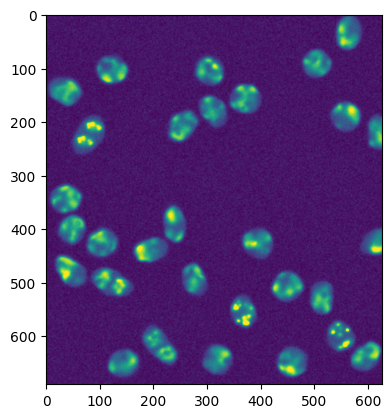

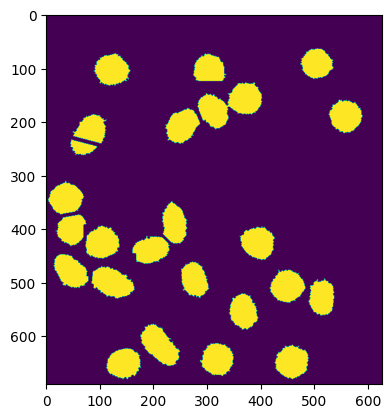

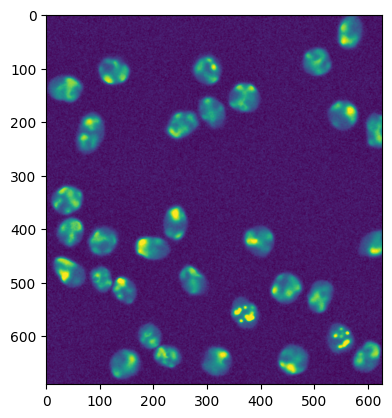

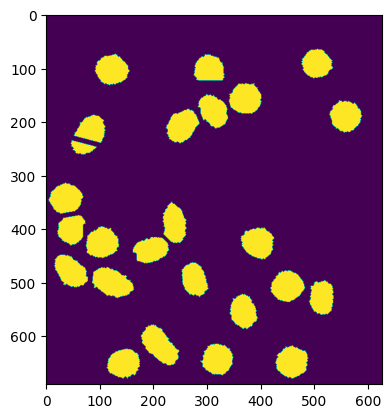

cell_S.label= 17
cell_S.solidity= 0.9232970807097882
cell centroid= [500. 123.]
best iou= 0.7784075573549257
best_a,best_b,best_c= -4 8 0.5
best iou= 0.6072445019404916
best_e,best_f,best_g,best_deg= 7 18 1.01 0
foci1 value= 1
foci2 value= 1
foci1= [40, 18]
foci2= [40, 73]
focy1= [40, 28]
focy2= [40, 53]
the cell is not mitosis.


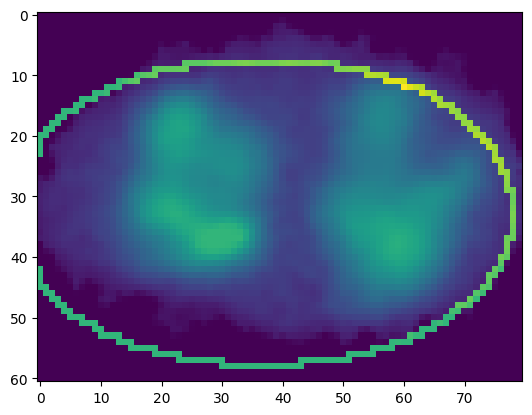

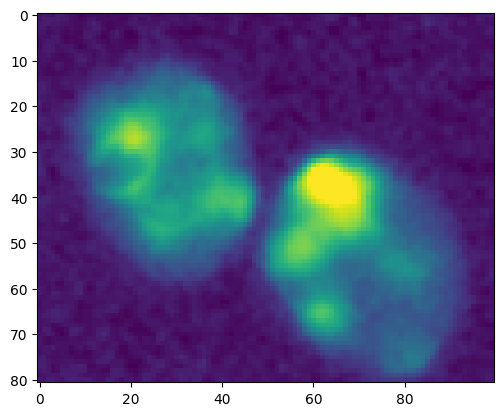

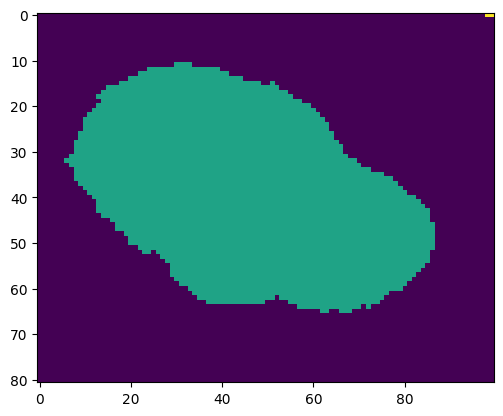

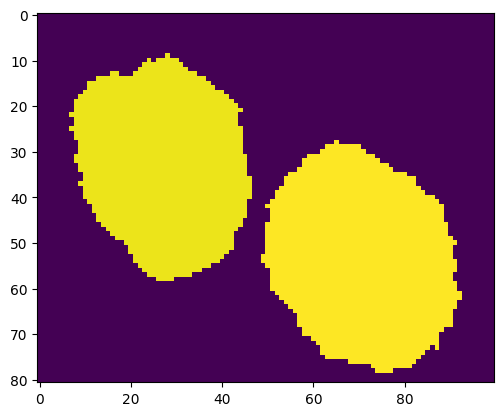

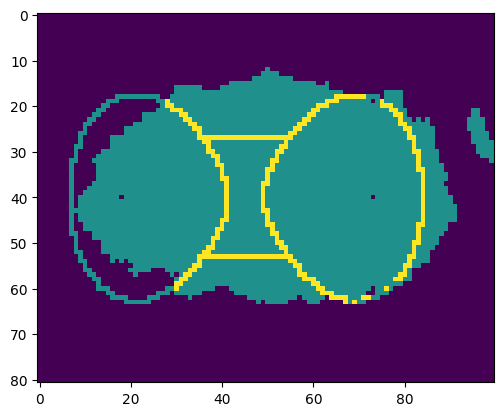

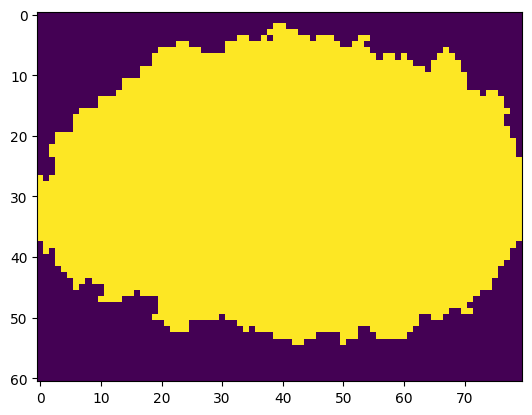

This cell finished in 41 seconds.


----------------------------------------------------------------------------------------
cell_S.label= 18
cell_S.solidity= 0.9281590763309814
cell centroid= [507. 449.]
best iou= 0.8554480174836091
best_a,best_b,best_c= 0 4 0.5


KeyboardInterrupt: 

In [5]:
all_mitosis_num=0

a='F:/celltrackingdata/2D Data/Fluo-N2DH-SIM/01_gt/contain_mitosis/'
mask_names1= glob(a + "*.*")
mask_names1.pop()
mask_names2= glob(a + "*.*")
mask_names2.pop(0)

b='F:/celltrackingdata/2D Data/Fluo-N2DH-SIM/01/contain_mitosis/'
img_names1= glob(b + "*.*")
img_names1.pop()
img_names2= glob(b + "*.*")
img_names2.pop(0)

mito_num=0

for imgn in zip(mask_names1,mask_names2,img_names1,img_names2):
    print(imgn[0])
    print(imgn[1])

    gt1= cv2.imread(imgn[0],cv2.IMREAD_ANYDEPTH)
    gt2= cv2.imread(imgn[1],cv2.IMREAD_ANYDEPTH)

    labels1 = clear_border(gt1)
    labels2 = clear_border(gt2)

    image1=cv2.imread(imgn[2],cv2.IMREAD_ANYDEPTH)
    image1=cv2.GaussianBlur(image1,(3,3),0)
    p2, p98 = np.percentile(image1, (0.2, 99.8),method='median_unbiased')
    image1 = skimage.exposure.rescale_intensity(image1, in_range=(p2, p98))
    image1 = (image1 - image1.min()) / (image1.max() - image1.min())
    image1 = skimage.exposure.equalize_adapthist(image1, clip_limit=0.01).astype(np.float32)# Adaptive Equalization    
    
    thresholds =threshold_triangle(image1)
    cells = image1 > thresholds
    cells=remove_small_holes(cells,256, connectivity=1)
    segmented_cells = clear_border(cells)
    segmented_cells =split_cell2(segmented_cells)
    #segments_fz = median(segments_fz, disk(3))
    segmented_cells=binary_erosion(segmented_cells)
    segmented_cells=remove_small_holes(segmented_cells,256, connectivity=2)
    segmented_cells=remove_small_objects(segmented_cells,256)    
    
    plt.imshow(image1),plt.show()

    plt.imshow(segmented_cells),plt.show()
    
    seg1= measure.label(segmented_cells, background=0)
    

    image2=cv2.imread(imgn[3],cv2.IMREAD_ANYDEPTH)
    image2=cv2.GaussianBlur(image2,(3,3),0)
    p2, p98 = np.percentile(image2, (0.2, 99.8),method='median_unbiased')
    image2 = skimage.exposure.rescale_intensity(image2, in_range=(p2, p98))
    image2 = (image2 - image2.min()) / (image2.max() - image2.min())
    image2 = skimage.exposure.equalize_adapthist(image2, clip_limit=0.01).astype(np.float32)# Adaptive Equalization

    thresholds =threshold_triangle(image2)
    cells = image2 > thresholds
    cells=remove_small_holes(cells,256, connectivity=1)
    segmented_cells = clear_border(segmented_cells)
    segmented_cells =split_cell2(segmented_cells)
    #segments_fz = median(segments_fz, disk(3))
    segmented_cells=binary_erosion(segmented_cells)
    segmented_cells=remove_small_holes(segmented_cells,256, connectivity=2)
    segmented_cells=remove_small_objects(segmented_cells,256)  
    
    plt.imshow(image2)
    plt.show()

    plt.imshow(segmented_cells)
    plt.show()
    
    seg2= measure.label(segmented_cells, background=0)
    
    cells_S = measure.regionprops(label_image=seg1, intensity_image=image1, cache=True)
    
    for cell_S in cells_S:
        t_start = perf_counter()

        if(cell_S.label>=17):
            best_iou=0
            print('cell_S.label=',cell_S.label)
            print('cell_S.solidity=',cell_S.solidity)

            print('cell centroid=',np.round(cell_S.centroid))

            rot_img=cell_S.image_intensity

            angle_in_degrees = cell_S.orientation * (180/np.pi) + 90 

            rot_img=rotate(rot_img, -angle_in_degrees, resize=False)

            cas_img=np.zeros_like(rot_img)

            cas_origin=(cas_img.shape[0]/2,cas_img.shape[1]/2)
            #cas_origin=cell_S.centroid

            #print('orientation=',cell_S.orientation)

            for a in range(-10,2,2):
                for b in range(4,25,4):
                    for c in range(5,7,1):
                        p,_,_=mycassini(A=c/10,x_scale=cell_S.axis_major_length,x_bias=a,
                            y_scale=cell_S.axis_minor_length,y_bias=b)

                        #p=mycassini(x_scale=cell_S.image_intensity.shape[1]-1,x_bias=x_dif,
                            #y_scale=cell_S.image_intensity.shape[0]-1,y_bias=y_dif)
                        cas_img1=np.zeros_like(rot_img)                           
                        image_cas1 = cv2.fillPoly(cas_img1, [p], color= (255))
                        image_cas1=(image_cas1>0)*1.0
                        cell_binery=(cell_S.image_filled>0)*1.0
                        intersection=(image_cas1 * cell_binery).sum()
                        union=(image_cas1 + cell_binery).sum() 
                        iou = (intersection / (union-intersection) )
                        if(iou>best_iou):
                            best_iou=iou
                            best_a,best_b,best_c=a,b,c/10



            p_best,_,_=mycassini(A=0.5,x_scale=cell_S.axis_major_length,x_bias=best_a,
                                y_scale=cell_S.axis_minor_length,y_bias=best_b)
            cas_img=np.zeros_like(rot_img)
            image_cas = cv2.polylines(cas_img, [p_best],isClosed= True, color= (255), thickness= 1)
            print('best iou=',best_iou)
            print('best_a,best_b,best_c=',best_a,best_b,best_c)
            image_cas = (image_cas - image_cas.min()) / (image_cas.max() - image_cas.min())

            current_img=rot_img+image_cas

            #plt.imshow(rot_img+image_cas),plt.show()

##############################################################################################################
#next frame

            pre_img=cell_S.image_intensity
            min_row=int(cell_S.bbox[0])
            min_col=int(cell_S.bbox[1])
            max_row=int(cell_S.bbox[2])
            max_col=int(cell_S.bbox[3])
            offset=10
            lrow=0
            if(min_row>=offset):
                min_row-=offset

            if(min_col>=offset):
                min_col-=offset

            max_row+=offset
            if(max_row>seg2.shape[0]):
                max_row=seg2.shape[0]

            max_col+=offset
            if(max_col>seg2.shape[1]):
                max_col=seg2.shape[1]

            #next_img=seg2[cell_S.bbox[0]:cell_S.bbox[2],cell_S.bbox[1]:cell_S.bbox[3]]

            next_img=seg2[min_row:max_row,min_col:max_col]  
            #next_img = clear_border(next_img)
            #next_img_area=np.sum(next_img>0)

            if(True):                        

                next_intensi_img=image2[min_row:max_row,min_col:max_col]                    
                next_lbl=labels2[min_row:max_row,min_col:max_col]
                current_lbl=labels1[min_row:max_row,min_col:max_col] 

                angle_in_degrees = cell_S.orientation * (180/np.pi) + 90 

                next_img=rotate(next_img, -angle_in_degrees, resize=False)

                next_cas_img=np.zeros_like(next_img)

                cas_origin=(next_cas_img.shape[0]/2,next_cas_img.shape[1]/2)
                best_iou=0
                best_g=1
                best_e=4
                best_f=0
                best_deg=0
                for e in range(0,35,7):
                    for f in range(4,35,7):
                        for g in range(1,21,4):                                
                            for deg in range(0,180,30):                                    

                                q,_,_=mycassini(A=1+ g/100,x_scale=cell_S.axis_major_length,x_bias=e,
                                    y_scale=cell_S.axis_minor_length,y_bias=f)

                                cas_img1=np.zeros_like(next_cas_img)                           
                                image_cas1 = cv2.fillPoly(cas_img1, [q], color= (255))
                                image_cas1=(image_cas1>0)*1.0

                                next_img=seg2[min_row:max_row,min_col:max_col]
                                #next_img = clear_border(next_img)
                                next_img=rotate(next_img, -(angle_in_degrees+deg), resize=False)
                                #plt.imshow(next_img),plt.show()
                                cell_binery=(next_img>0)*1.0
                                intersection=(image_cas1 * cell_binery).sum()
                                union=(image_cas1 + cell_binery).sum() 
                                iou = (intersection / (union-intersection) )
                                if(iou>best_iou):
                                    best_iou=iou
                                    best_e,best_f,best_g,best_deg=e,f,1+ g/100,deg



                q_best,foci1,foci2=mycassini(A=best_g,x_scale=cell_S.axis_major_length-5,x_bias=best_e,
                                    y_scale=cell_S.axis_minor_length-5,y_bias=best_f)

                cas_img=np.zeros_like(next_cas_img)
                image_cas = cv2.polylines(cas_img, [q_best],isClosed= True, color= (255), thickness= 1)

                image_cas2 = cv2.fillPoly(np.zeros_like(cas_img1), [q_best], color= (255))


                print('best iou=',best_iou)
                print('best_e,best_f,best_g,best_deg=',best_e,best_f,best_g,best_deg)
                image_cas = (image_cas - image_cas.min()) / (image_cas.max() - image_cas.min())

                next_img=seg2[min_row:max_row,min_col:max_col]                                       
                #next_img = clear_border(next_img)
                next_img=rotate(next_img, -(angle_in_degrees+best_deg), resize=False)

                next_img=(next_img>0)
                next_img= measure.label(next_img, background=0)                       

                #print('next_img.shape=',next_img.shape)
                if(foci1[0]>=next_img.shape[1]):
                    foci1[0]=next_img.shape[1]-1

                if(foci1[1]>=next_img.shape[0]):
                    foci1[1]=next_img.shape[0]-1

                if(foci2[0]>=next_img.shape[1]):
                    foci2[0]=next_img.shape[1]-1

                if(foci2[1]>=next_img.shape[0]):
                    foci2[1]=next_img.shape[0]-1

                foci1_value=next_img[foci1[1],foci1[0]]
                foci2_value=next_img[foci2[1],foci2[0]]

                print('foci1 value=',foci1_value)
                print('foci2 value=',foci2_value)

                focy1=[foci1[1],foci1[0]]
                focy2=[foci2[1],foci2[0]]

                print('foci1=',focy1)
                print('foci2=',focy2)

                focy1=[foci1[1],foci1[0]+ int(offset)]
                focy2=[foci2[1],foci2[0]- 20]

                print('focy1=',focy1)
                print('focy2=',focy2)

                original_img=rotate(cell_S.image, -(angle_in_degrees+best_deg), resize=False)
                original_img= measure.label(original_img, background=0)
                cells_T = measure.regionprops(label_image=original_img)    

                bb1=np.equal(focy1, cells_T[0].coords).all(axis=1).any()
                bb2=np.equal(focy2, cells_T[0].coords).all(axis=1).any()


                if(foci1_value*foci2_value>0):
                    if(foci1_value==foci2_value):
                        print('the cell is not mitosis.')
                    else:
                        if(bb1.all() and bb2.all()):
                            print('the cell is mitosis!!!!!')
                            print('the image is=',imgn[0])
                            print('cell centroid=',np.round(cell_S.centroid))
                            all_mitosis_num+=1
                            print('number of mitosis=',all_mitosis_num)
                        else:
                            print('the cell is not mitosis. cuz focis arent in mother cell roi.')

                else:
                    print('the cell is not mitosis.')                    

                plt.imshow(current_img),plt.show()
                plt.imshow(next_intensi_img),plt.show()

                plt.imshow(current_lbl),plt.show()                            
                plt.imshow(next_lbl),plt.show() 
                next_img=(next_img>0)*1.0 

                next_img[foci1[1],foci1[0]]=0
                next_img[foci2[1],foci2[0]]=0

                plt.imshow(next_img+image_cas),plt.show()

                plt.imshow(original_img),plt.show()


            print(f"This cell finished in {round(perf_counter()-t_start)} seconds.\r\n")

            print('\r\n----------------------------------------------------------------------------------------')
